<h1 id="tocheading">Fraud Detection with XGBoost and Machine Learning in DSX Local</h1>
<div id="toc"></div>


In [7]:

%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')


<IPython.core.display.Javascript object>

## Imports

In [10]:
from datetime import datetime

## UDFs

In [171]:
from collections import defaultdict

def reverse_dummy(df_dummies):
    pos = defaultdict(list)
    vals = defaultdict(list)

    for i, c in enumerate(df_dummies.columns):
        if "_" in c:
            k, v = c.split("_", 1)
            pos[k].append(i)
            vals[k].append(v)
        else:
            pos["_"].append(i)

    df = pd.DataFrame({k: pd.Categorical.from_codes(
                              np.argmax(df_dummies.iloc[:, pos[k]].values, axis=1),
                              vals[k])
                      for k in vals})

    df[df_dummies.columns[pos["_"]]] = df_dummies.iloc[:, pos["_"]]
    return df

## Load History Transaction Data

In [8]:
import os, pandas as pd
# Add asset from file system
df_data_1 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/History_Transactions_v4.csv').drop("Hours Since Last Transaction", 1)
df_data_1.head()

,Account_Number,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Transaction_Time,last transaction time,Fraudulent,Transaction_Dates,Last_Trasaction_Dates,Last3hourTransactions,Hours_Since_Last_Transaction
0,12345679,188.56,swiped,ATM Withdrawal,E,USA,17:41:14,NaN,F,2017-04-26,NaN,4,21
1,12345679,160.54,keyed,Grocery,NE,Australia,01:22:12,17:41:14,F,2017-06-26,2017-04-26,3,21
2,12345679,153.24,swiped,Retail - Pharmacy,SW,European Union,12:14:55,01:22:12,T,2017-10-27,2017-06-26,2,21
3,12345679,148.66,keyed,Communications - telephone and wireless,NW,USA,20:22:44,12:14:55,F,NaN,2017-10-27,1,35
4,12345679,174.03,keyed,Spa/Beauty,SW,Asia,23:13:39,20:22:44,F,NaN,NaN,1,25


## Exploratory Data Analysis

In [8]:
# check missing
df_data_1.apply(lambda x: sum(x.isnull()))

Account_Number                      0
Dollar_Amount                       0
Transaction_Type                    0
Store_Type                          0
Cardholder_Region                   0
Country                             0
Transaction_Time                    0
last transaction time            2770
Fraudulent                          0
Transaction_Dates               11022
Last_Trasaction_Dates           11500
Last3hourTransactions               0
Hours_Since_Last_Transaction        0
dtype: int64

In [9]:
# Look at categorical variables
var = ['Fraudulent', 'Transaction_Type', 'Store_Type', 'Cardholder_Region', 'Country', 'Transaction_Time', 'Transaction_Dates', 'Last_Trasaction_Dates']
for v in var:
    print("****************************************")
    print('\nFrequency count for variable %s'%v)
    print(df_data_1[v].value_counts())

****************************************

Frequency count for variable Fraudulent
F    52132
T     2903
Name: Fraudulent, dtype: int64
****************************************

Frequency count for variable Transaction_Type
swiped    27623
keyed     27412
Name: Transaction_Type, dtype: int64
****************************************

Frequency count for variable Store_Type
Restaurant                                 4470
Professional Services                      3443
Grocery                                    3403
Gas                                        3261
Other                                      3226
Hotel                                      3206
Retail - Apparel                           2276
ATM Withdrawal                             2240
Retail - Furniture                         2232
Entertainment and Arts                     2207
Retail - Home Improvement                  2194
Retail - Drug Store                        2193
Communications - telephone and wireless    2191
Me

## Data Preparation

1. Since we already have variable **Hours_Since_Last_Transaction**, just remove transaction date related variables from further analysis.
2. Intuitively we know that unreasonable transaction time might be an indicator of suspicious activities. So we created a new variable based on transaction time => : 6:00 - 11:59, P: 12:00 - 21:59, L: 22:00 - 5:00 => Removed due to no contribution to model performance.
3. Use SMOTE to balance training set


In [12]:
# remove transaction date related variables
#df_data_1 = df_data_1.drop(['last transaction time', 'Transaction_Dates', 'Last_Trasaction_Dates'], 1)

# new indicator based on transaction time
df_data_1['Transaction_Time_ts'] = df_data_1.Transaction_Time.map(lambda l: datetime.strptime(l, "%H:%M:%S"))

df_data_1.loc[(df_data_1['Transaction_Time_ts'] >= datetime.strptime("06:00:00", "%H:%M:%S")) & (df_data_1['Transaction_Time_ts'] <= datetime.strptime("23:59:59", "%H:%M:%S")), "TimeofDay"] = "Morning"

df_data_1.loc[(df_data_1['Transaction_Time_ts'] >= datetime.strptime("12:00:00", "%H:%M:%S")) & (df_data_1['Transaction_Time_ts'] < datetime.strptime("22:00:00", "%H:%M:%S")), "TimeofDay"] = "Afternoon"

df_data_1.loc[((df_data_1['Transaction_Time_ts'] >= datetime.strptime("22:00:00", "%H:%M:%S")) & (df_data_1['Transaction_Time_ts'] < datetime.strptime("00:00:00", "%H:%M:%S")))|
              (df_data_1['Transaction_Time_ts'] >= datetime.strptime("00:00:00", "%H:%M:%S")) & (df_data_1['Transaction_Time_ts'] < datetime.strptime("06:00:00", "%H:%M:%S")), "TimeofDay"] = "LateNight"

df_data_1 = df_data_1.drop(['Transaction_Time',"Transaction_Time_ts"] , 1)

# remove TimeofDay
df_data_1 = df_data_1.drop(['TimeofDay'], 1)

In [13]:
df_data_1.columns

Index(['Account_Number', 'Dollar_Amount', 'Transaction_Type', 'Store_Type',
       'Cardholder_Region', 'Country', 'Fraudulent', 'Last3hourTransactions',
       'Hours_Since_Last_Transaction'],
      dtype='object')

### Split data into training and testing

In [14]:
y = df_data_1['Fraudulent'].map(lambda l: 1 if l == 'T' else 0)
X = df_data_1.drop(['Fraudulent', 'Account_Number'], axis=1)

In [15]:
from sklearn.cross_validation import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234567)

print("Number of training records: " + str(len(X_train)))
print("Number of testing records : " + str(len(X_test)))

Number of training records: 44028
Number of testing records : 11007


## Handle Imbalance using SMOTE

In [260]:
#!pip install -U imbalanced-learn --user

Requirement already up-to-date: imbalanced-learn in /user-home/1018/.local/lib/python3.5/site-packages
Requirement already up-to-date: scipy in /opt/conda/lib/python3.5/site-packages (from imbalanced-learn)
Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.5/site-packages (from imbalanced-learn)
Requirement already up-to-date: numpy in /opt/conda/lib/python3.5/site-packages (from imbalanced-learn)


In [16]:
# restart kernel if see error
from imblearn.over_sampling import SMOTE

In [17]:
X_train_dummy = pd.get_dummies(X_train)

In [18]:
sm = SMOTE(random_state=2662761, ratio = 'auto', k_neighbors = 5)
X_train_res, y_train_res = sm.fit_sample(X_train_dummy, y_train)


print('Fraud/Non-Fraud Ratio Before SMOTE: ' + str(y_train.sum()/len(y_train)))
print('Fraud/Non-Fraud Ratio After SMOTE: ' + str(y_train_res.sum()/len(y_train_res)))

print("Fraud in Training after SMOTE = T: " + str(sum(y_train_res)))
print("Fraud in Training after SMOTE = F: " + str(len(y_train_res) - sum(y_train_res)))


Fraud/Non-Fraud Ratio Before SMOTE: 0.0523303352412
Fraud/Non-Fraud Ratio After SMOTE: 0.5
Fraud in Training after SMOTE = T: 41724
Fraud in Training after SMOTE = F: 41724


## XGboost

### Build Model

In [19]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import plot_importance
from matplotlib import pyplot
import pprint
%matplotlib inline

In [20]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [21]:
rcParams['figure.figsize'] = 12, 8

def modelfit(alg, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train_res, label=y_train_res)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train_res, y_train_res,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train_res)
    dtrain_predprob = alg.predict_proba(X_train_res)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : " + str(metrics.accuracy_score(y_train_res, dtrain_predictions)))
    print("AUC Score (Train): " + str(metrics.roc_auc_score(y_train_res, dtrain_predprob)))
                    
    feat_imp = pd.Series(alg._Booster.get_fscore()).sort_values()
    x=[]
    for i in range(0, len(feat_imp.index)):
        x.append( "f"+ str(i))
    feat_imp_reindex = feat_imp.rename(lambda y: dict(zip(x, X_train_dummy.columns.tolist()))[y])
    feat_imp_reindex.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return alg


Model Report
Accuracy : 0.971635030198
AUC Score (Train): 0.988011167901


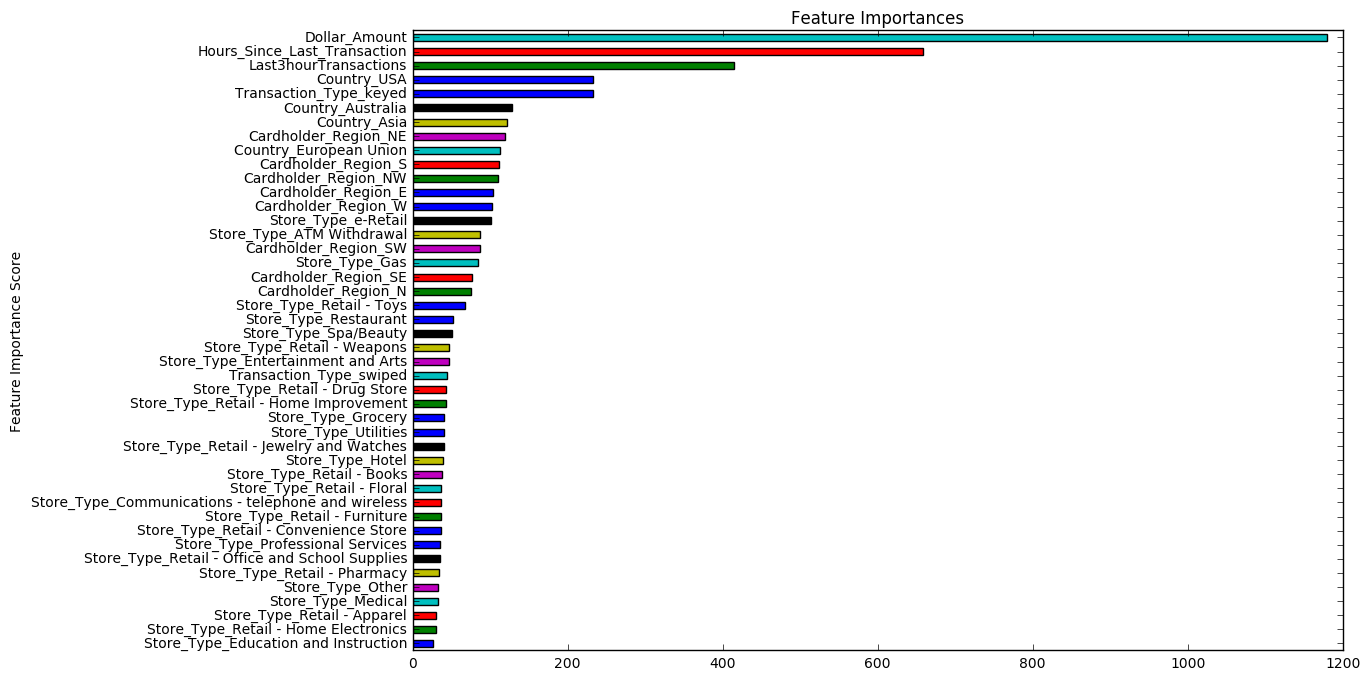

In [22]:
xgb_model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=24)

alg_out = modelfit(xgb_model)

In [43]:
pred = alg_out.predict(pd.get_dummies(X_test).as_matrix())

In [44]:
sum(pred )

0

In [33]:
pd.get_dummies(X_test).as_matrix()

array([[ 234.55,    4.  ,   19.  , ...,    0.  ,    0.  ,    1.  ],
       [ 151.65,    2.  ,   22.  , ...,    0.  ,    0.  ,    0.  ],
       [ 188.87,    1.  ,   27.  , ...,    0.  ,    0.  ,    0.  ],
       ..., 
       [ 186.64,    5.  ,   24.  , ...,    0.  ,    1.  ,    0.  ],
       [ 209.66,    6.  ,   14.  , ...,    0.  ,    0.  ,    0.  ],
       [ 151.39,    3.  ,   23.  , ...,    0.  ,    0.  ,    1.  ]])

In [34]:
sum(y_test)

599

In [23]:

alg_out.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 160,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 24,
 'silent': 1,
 'subsample': 0.8}

In [1]:
alg_out.predict(X_test)

NameError: name 'alg_out' is not defined

In [567]:
param_range = {
 'max_depth':[2,4,6],
 'min_child_weight':[1,3,5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=160, max_depth=6,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=24), 
 param_grid = param_range, scoring='roc_auc',n_jobs=4,iid=False, cv=5)


gsearch1.fit(X_train_res,y_train_res)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: 

In [568]:
### test curent
cv_params = {'max_depth': [2,4,6], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':24, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1) 

In [ ]:
optimized_GBM.fit(X_train_res, y_train_res)

In [ ]:
optimized_GBM.grid_scores_

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 4, 6, 8]
        }

In [ ]:
xgb = XGBClassifier(learning_rate=0.01, n_estimators= 10, objective='binary:logistic',
                    silent=True, nthread=1)

In [354]:
pipeline2 = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier(objective='binary:logistic', num_boost_round=10, colsample_bytree= 0.7,
learning_rate= 0.05,
max_depth= 6,
min_child_weight= 5,
missing= -999,
n_estimators= 5,
nthread=4,
seed=1337,
silent=1,
subsample=0.8))])

pipeline2.fit(X_train_res, y_train_res)



Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=5, missing=-999, n_estimat..., reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=1,
       subsample=0.8))])

In [355]:
y_pred2 = pipeline2.predict(pd.get_dummies(X_test))

In [356]:
sum(y_pred2)

22

In [352]:
sum(y_test)

565

In [358]:
roc = roc_auc_score(y_test, y_pred2)
print("ROC: " +  str(roc))

ROC: 0.505476780818


In [21]:
from sklearn.preprocessing import LabelBinarizer
from sklearn_pandas import DataFrameMapper
mapper1 = DataFrameMapper(
    [('Transaction_Type', LabelBinarizer()),
     ('Store_Type', LabelBinarizer()),
     ('Cardholder_Region', LabelBinarizer()),
     ('Country', LabelBinarizer()),
     ('TimeofDay', LabelBinarizer())])

In [271]:
mapper1 = DataFrameMapper(
    [('Transaction_Type', LabelBinarizer()),
     ('Store_Type', LabelBinarizer()),
     ('Cardholder_Region', LabelBinarizer()),
     ('Country', LabelBinarizer())
     ])

In [272]:
pipeline = Pipeline([('mapper', mapper1),('scaler', StandardScaler()), ('classifier', XGBClassifier())])

In [273]:
pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('Transaction_Type', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('Store_Type', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('Cardholder_Region', LabelBinarizer(neg_label=0, pos_l...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [70]:
pipeline2 = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier(max_depth=10, objective='binary:logistic', num_boost_round=10, learning_rate = .3))])
pipeline2.fit(X_train_res, y_train_res)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimator... reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))])

In [71]:
y_pred2 = pipeline2.predict(X_test2)

In [72]:
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(y_test2, y_pred2)
print("ROC: " +  str(roc))

ROC: 0.501047707777


In [74]:
xgb_model = xgb.XGBClassifier()
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [104]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [105]:
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV
clf = GridSearchCV(xgb_model, params, n_jobs=5, 
                   cv=StratifiedKFold(y_train_res,n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

In [106]:
clf.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV] gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.6 
[CV] gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.6 
[CV] gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.6 
[CV] gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.6 
[CV] gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.6 
[CV]  gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.6 -  18.6s
[CV] gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.8 
[CV]  gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.6 -  19.2s
[CV] gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.8 
[CV]  gamma=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.6, subsample=0.6 -  19.1s
[CV] gamma=0.5, min_child_weight=1, max_depth=3, 

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.1min


[CV] gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=0.8 
[CV]  gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=0.6 -  19.0s
[CV] gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=0.8 
[CV]  gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=0.6 -  19.6s
[CV] gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=0.8 
[CV]  gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=0.6 -  19.3s
[CV] gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=0.8 
[CV]  gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=0.8 -  17.3s
[CV] gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=1.0 
[CV]  gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=0.8 -  17.2s
[CV] gamma=0.5, min_child_weight=10, max_depth=3, colsample_bytree=0.6, subsample=1.0

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 11.3min


[CV]  gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=0.6 -  18.9s
[CV] gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=0.8 
[CV]  gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=0.6 -  19.1s
[CV] gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=0.8 
[CV]  gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=0.6 -  19.1s
[CV] gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=0.8 
[CV]  gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=0.8 -  17.1s
[CV] gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=1.0 
[CV]  gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=0.8 -  17.4s
[CV] gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=1.0 
[CV]  gamma=1, min_child_weight=5, max_depth=3, colsample_bytree=0.6, subsample=0.8 -  17.2s
[CV] gamma=1, min_chil

[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 25.9min


[CV]  gamma=1.5, min_child_weight=10, max_depth=4, colsample_bytree=0.6, subsample=1.0 -  20.0s
[CV] gamma=1.5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=0.6 
[CV]  gamma=1.5, min_child_weight=10, max_depth=4, colsample_bytree=0.6, subsample=1.0 -  20.2s
[CV] gamma=1.5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=0.6 
[CV]  gamma=1.5, min_child_weight=10, max_depth=4, colsample_bytree=0.6, subsample=1.0 -  20.3s
[CV] gamma=1.5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=0.6 
[CV]  gamma=1.5, min_child_weight=10, max_depth=4, colsample_bytree=0.6, subsample=1.0 -  20.3s
[CV] gamma=1.5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=0.6 
[CV]  gamma=1.5, min_child_weight=10, max_depth=4, colsample_bytree=0.6, subsample=1.0 -  20.1s
[CV] gamma=1.5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=0.6 
[CV]  gamma=1.5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=0.6 -  3

[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 47.3min


[CV]  gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=0.8 -  28.5s
[CV] gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=1.0 
[CV]  gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=0.8 -  27.4s
[CV] gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=1.0 
[CV]  gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=1.0 -  24.7s
[CV] gamma=5, min_child_weight=5, max_depth=5, colsample_bytree=0.6, subsample=0.6 
[CV]  gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=1.0 -  25.9s
[CV] gamma=5, min_child_weight=5, max_depth=5, colsample_bytree=0.6, subsample=0.6 
[CV]  gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=1.0 -  24.7s
[CV] gamma=5, min_child_weight=5, max_depth=5, colsample_bytree=0.6, subsample=0.6 
[CV]  gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=0.6, subsample=1.0 -  26.4s
[CV] gamma=5, min_chil

[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed: 80.7min


[CV]  gamma=1.5, min_child_weight=1, max_depth=4, colsample_bytree=0.8, subsample=1.0 -  25.6s
[CV] gamma=1.5, min_child_weight=5, max_depth=4, colsample_bytree=0.8, subsample=0.6 
[CV]  gamma=1.5, min_child_weight=1, max_depth=4, colsample_bytree=0.8, subsample=1.0 -  25.4s
[CV] gamma=1.5, min_child_weight=5, max_depth=4, colsample_bytree=0.8, subsample=0.6 
[CV]  gamma=1.5, min_child_weight=5, max_depth=4, colsample_bytree=0.8, subsample=0.6 -  31.2s
[CV] gamma=1.5, min_child_weight=5, max_depth=4, colsample_bytree=0.8, subsample=0.8 
[CV]  gamma=1.5, min_child_weight=5, max_depth=4, colsample_bytree=0.8, subsample=0.6 -  30.5s
[CV] gamma=1.5, min_child_weight=5, max_depth=4, colsample_bytree=0.8, subsample=0.8 
[CV]  gamma=1.5, min_child_weight=5, max_depth=4, colsample_bytree=0.8, subsample=0.6 -  30.8s
[CV] gamma=1.5, min_child_weight=5, max_depth=4, colsample_bytree=0.8, subsample=0.8 
[CV]  gamma=1.5, min_child_weight=5, max_depth=4, colsample_bytree=0.8, subsample=0.6 -  31.4s


[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 124.9min


[CV] gamma=0.5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=1.0 
[CV]  gamma=0.5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=0.8 -  41.8s
[CV] gamma=0.5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=1.0 
[CV]  gamma=0.5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=1.0 -  38.5s
[CV] gamma=0.5, min_child_weight=5, max_depth=5, colsample_bytree=1.0, subsample=0.6 
[CV]  gamma=0.5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=1.0 -  38.6s
[CV] gamma=0.5, min_child_weight=5, max_depth=5, colsample_bytree=1.0, subsample=0.6 
[CV]  gamma=0.5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=1.0 -  37.9s
[CV] gamma=0.5, min_child_weight=5, max_depth=5, colsample_bytree=1.0, subsample=0.6 
[CV]  gamma=0.5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=1.0 -  38.5s
[CV] gamma=0.5, min_child_weight=5, max_depth=5, colsample_bytree=1.0, subsample=0.6 
[CV]  gam

[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed: 184.8min


[CV]  gamma=5, min_child_weight=10, max_depth=4, colsample_bytree=1.0, subsample=1.0 -  31.3s
[CV] gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=0.6 
[CV]  gamma=5, min_child_weight=10, max_depth=4, colsample_bytree=1.0, subsample=1.0 -  31.1s
[CV] gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=0.6 
[CV]  gamma=5, min_child_weight=10, max_depth=4, colsample_bytree=1.0, subsample=1.0 -  30.8s
[CV] gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=0.6 
[CV]  gamma=5, min_child_weight=10, max_depth=4, colsample_bytree=1.0, subsample=1.0 -  31.0s
[CV] gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=0.6 
[CV]  gamma=5, min_child_weight=10, max_depth=4, colsample_bytree=1.0, subsample=1.0 -  31.4s
[CV] gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=0.6 
[CV]  gamma=5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, subsample=0.6 -  46.3s
[CV] gamma=5, min

[Parallel(n_jobs=5)]: Done 2025 out of 2025 | elapsed: 191.5min finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 1 1], n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 5, 10], 'max_depth': [3, 4, 5], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [86]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Raw AUC score: 0.6687008657621656
colsample_bytree: 0.7
learning_rate: 0.05
max_depth: 6
min_child_weight: 11
missing: -999
n_estimators: 5
nthread: 4
objective: 'binary:logistic'
seed: 1337
silent: 1
subsample: 0.8


In [92]:
test_probs = clf.predict_proba(X_test2)[:,1]

In [93]:
roc = roc_auc_score(y_test2, clf.predict(X_test2))
print("ROC: " +  str(roc))

ROC: 0.5


In [98]:
clf.predict(X_test2).tolist()

16511

### Model Evaluation

In [38]:
y_pred = pipeline.predict(X_test)

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(y_test, y_pred)
print("ROC: " +  str(roc))

ROC: 0.5


## Model Deployment

In [128]:
from dsx_ml.ml import save

Using TensorFlow backend.


In [132]:
model_name = "local_xgb_test_addtrsfm"
save(name = model_name,
     model = pipeline,
     algorithm_type = 'Classification',
     x_test = X_test,
     y_test = pd.DataFrame(y_test))

TypeError: save() got an unexpected keyword argument 'Accuracy'

### Online Scoring

In [171]:
json_payload =[{
    'Dollar_Amount': 1000,
    'Transaction_Type':' keyed',
    'Store_Type': 'Retail - Furniture',
    'Cardholder_Region': 'SW',
    'Country': 'Asia',
    'Last3hourTransactions': 100,
    'Hours_Since_Last_Transaction': 12,
    'TimeofDay': 'L' }]

In [172]:
import requests, json, os
from pprint import pprint

online_path='https://dsxl-api.ibm-private-cloud.svc.cluster.local/v3/project/score/Python35/scikit-learn-0.19/DTE%20FSS%20Fraud%20Detection/local_xgb_test_addtrsfm/1'
header_online = {'Content-Type': 'application/json', 'Authorization':os.environ['DSX_TOKEN']}

response_scoring = requests.post(online_path, json=json_payload, headers=header_online)

response_dict = json.loads(response_scoring.content.decode('utf-8'))

pred=response_dict['object']['output']['predictions']
prob=response_dict['object']['output']['probabilities']
print("Prediction: %s" % pred)
print("Probabilities: %s" % prob)

Prediction: [0]
Probabilities: [[0.9734798669815063, 0.02652011252939701]]


### Batch Scoring

** Preparing data for Batch Scoring **

In [173]:
df_data_2 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/Current_Transactions_v6.csv').drop("Hours Since Last Transaction", 1)
df_data_2.head()

,Account_Number,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Transaction_Time,last transaction time,Transaction_Dates,Last_transaction_dates,Last3hourTransactions,Hours_Since_Last_Transaction
0,12345680,171.72,keyed,Utilities,NW,USA,11:48:31,7:05:17,1/2/18,1/2/18,1,15
1,12345681,152.98,keyed,Retail - Books,NE,USA,11:14:29,NaN,1/3/18,1/3/18,2,21
2,12345681,126.30,swiped,Retail - Home Improvement,S,USA,21:09:07,11:14:29,1/4/18,1/4/18,1,18
3,12345681,126.30,swiped,Retail - Home Improvement,S,USA,23:06:19,21:09:07,1/5/18,1/5/18,2,14
4,12345682,181.16,keyed,Retail - Pharmacy,N,USA,1:07:48,NaN,1/6/18,1/6/18,2,23


In [174]:
# remove transaction date related variables
df_data_2 = df_data_2.drop(['last transaction time', 'Transaction_Dates', 'Last_transaction_dates', 'Account_Number'], 1)

# new indicator based on transaction time
df_data_2['Transaction_Time_ts'] = df_data_2.Transaction_Time.map(lambda l: datetime.strptime(l, "%H:%M:%S"))

df_data_2.loc[(df_data_2['Transaction_Time_ts'] >= datetime.strptime("06:00:00", "%H:%M:%S")) & (df_data_2['Transaction_Time_ts'] <= datetime.strptime("23:59:59", "%H:%M:%S")), "TimeofDay"] = "A"

df_data_2.loc[(df_data_2['Transaction_Time_ts'] >= datetime.strptime("12:00:00", "%H:%M:%S")) & (df_data_2['Transaction_Time_ts'] < datetime.strptime("22:00:00", "%H:%M:%S")), "TimeofDay"] = "A"

df_data_2.loc[((df_data_2['Transaction_Time_ts'] >= datetime.strptime("22:00:00", "%H:%M:%S")) & (df_data_2['Transaction_Time_ts'] < datetime.strptime("00:00:00", "%H:%M:%S")))|
              (df_data_2['Transaction_Time_ts'] >= datetime.strptime("00:00:00", "%H:%M:%S")) & (df_data_2['Transaction_Time_ts'] < datetime.strptime("06:00:00", "%H:%M:%S")), "TimeofDay"] = "L"

df_data_2 = df_data_2.drop(['Transaction_Time',"Transaction_Time_ts"] , 1)

** Batch Scoring **

Note: Modified the auto-generated script to make it work within notebook for batch scoring.


In [245]:
import pandas as pd
from sklearn import model_selection
from sklearn.externals import joblib
import pickle
import sys, os
import json
sys.path.insert(0, '/user-home/.scripts/common-helpers')
import published_model_util

# name your input and output data
test_csv = "Current_Transactions_v6_test2.csv" # dont have to 
save_csv = "yhat.csv"
args={'source': '/datasets/'+ test_csv, 'execution_type': 'DSX', 'target': '/datasets/'+ save_csv}
#input_data = os.getenv("DSX_PROJECT_DIR")+args.get("source")
output_data = os.getenv("DSX_PROJECT_DIR")+"/datasets/"+save_csv
model_name = 'local_xgb_test_addtrsfm'
model_path = os.getenv("DSX_PROJECT_DIR")+"/models/"+model_name+"/1/model"
project_name = 'DTE FSS Fraud Detection'
is_published = 'false'

def scoring(model_path, input_data, output_data):
    published_path = ''
    # load model
    if is_published == 'true':
        copy_result = json.loads(published_model_util.copy_model(project_name, model_name))
        if(copy_result['code'] == 200):
            model_path = copy_result['path'] + '/model'
            published_path = copy_result['path']
        else:
            raise Exception('Unable to score published model: ' + copy_result['description'])

   # load the input data
    dataframe = input_data

    # load the model from disk 
    loaded_model = joblib.load(open(model_path, 'rb'))
    
    #predictions
    scoring_result = loaded_model.predict(dataframe)

    # feel free to write any code
    #print(scoring_result)
    scoring_output = pd.concat([dataframe.reset_index(drop=True), pd.DataFrame({'prediction':scoring_result})], 1)
    # save to csv
    scoring_output.to_csv(output_data)

    if (len(published_path) > 0):
        published_model_util.delete_temp_model()
    
    print("Done! The results have been saved as " + save_csv)
    
    return scoring_output

# invoke scoring: pay attention to input_data
batch_result = scoring(model_path,df_data_2, output_data)

Done! The results have been saved as yhat.csv


In [247]:
batch_result.head()

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Last3hourTransactions,Hours_Since_Last_Transaction,TimeofDay,prediction
0,171.72,keyed,Utilities,NW,USA,1,15,A,0
1,152.98,keyed,Retail - Books,NE,USA,2,21,A,0
2,126.30,swiped,Retail - Home Improvement,S,USA,1,18,A,0
3,126.30,swiped,Retail - Home Improvement,S,USA,2,14,A,0
4,181.16,keyed,Retail - Pharmacy,N,USA,2,23,L,0


In [238]:


df_data_3 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/smoteout.csv')
df_data_3.head()



,Account_Number,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Transaction_Time,last transaction time,Hours Since Last Transaction,Fraudulent,Transaction_Dates,Last_Trasaction_Dates,Last3hourTransactions,Hours_Since_Last_Transaction,Partition
0,12345679,188.56,swiped,ATM Withdrawal,E,USA,5:41:14 PM,NaN,NaN,F,26-Apr-17,NaN,4,21,1_Training
1,12345679,160.54,keyed,Grocery,NE,Australia,1:22:12 AM,5:41:14 PM,31.682778,F,26-Jun-17,26-Apr-17,3,21,1_Training
2,12345679,153.24,swiped,Retail - Pharmacy,SW,European Union,12:14:55 PM,1:22:12 AM,106.878611,T,27-Oct-17,26-Jun-17,2,21,1_Training
3,12345679,148.66,keyed,Communications - telephone and wireless,NW,USA,8:22:44 PM,12:14:55 PM,56.130278,F,NaN,27-Oct-17,1,35,2_Testing
4,12345679,174.03,keyed,Spa/Beauty,SW,Asia,11:13:39 PM,8:22:44 PM,26.848611,F,NaN,NaN,1,25,1_Training


In [240]:
df_data_3 = df_data_3.drop(['Account_Number','Transaction_Time', 'last transaction time', 'Hours Since Last Transaction', 'Transaction_Dates',	'Last_Trasaction_Dates'], 1)

In [245]:
train = df_data_3[df_data_3.Partition == "1_Training"].drop('Partition', 1)


In [246]:
test = df_data_3[df_data_3.Partition == "2_Testing"].drop('Partition', 1)

In [264]:
mapper1 = DataFrameMapper(
    [('Transaction_Type', LabelBinarizer()),
     ('Store_Type', LabelBinarizer()),
     ('Cardholder_Region', LabelBinarizer()),
     ('Country', LabelBinarizer())
     ])

In [339]:
pipeline = Pipeline([('mapper', mapper1),('scaler', StandardScaler()), ('classifier', XGBClassifier(objective='binary:logistic', num_boost_round=10, colsample_bytree= 0.7,
learning_rate= 0.05,
max_depth= 6,
min_child_weight= 5,
missing= -999,
n_estimators= 5,
nthread=4,
seed=1337,
silent=1,
subsample=0.8))])

In [311]:
y = train['Fraudulent'].map(lambda l: 1 if l == 'T' else 0)
X = train.drop(['Fraudulent'], axis=1)

In [340]:
pipeline.fit(X, y)

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('Transaction_Type', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('Store_Type', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('Cardholder_Region', LabelBinarizer(neg_label=0, pos_l..., reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=1,
       subsample=0.8))])

In [307]:
y_test = test['Fraudulent'].map(lambda l: 1 if l == 'T' else 0)
X_test = test.drop(['Fraudulent'], axis=1)

In [341]:
y_pred =pipeline.predict(X_test)

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [342]:
roc = roc_auc_score(y_test,y_pred)
print("ROC: " +  str(roc))

ROC: 0.574475544912


In [344]:
sum(y_test)

565